# Tutorial

## Motivation


Project efforts such as the [Coupled Model Intercomparison Project (CMIP)](https://www.wcrp-climate.org/wgcm-cmip) and other coordinated climate model runs (like CORDEX, Miklip, MPI-M Large Ensemble ..) produce a huge of amount climate data persisted on tape, disk storage, object storage components across multiple (in the order of ~ 300,000) data assets. These data assets are stored in netCDF and more recently [Zarr](https://zarr.readthedocs.io/en/stable/) formats. Finding, investigating, loading these assets into data array containers such as xarray can be a daunting task due to the large number of files a user may be interested in. Intake-esm aims to address these issues by providing necessary functionality for searching, discovering, data access/loading. 

## Overview 

`intake-esm` is a data cataloging utility built on top of [intake](https://github.com/intake/intake), [pandas](https://pandas.pydata.org/), and [xarray](https://xarray.pydata.org/en/stable/), and it's pretty awesome! 


## Opening a collection

First step is to point ``intake-esm`` to an ESM (Earth System Model) collection definition file, which is a JSON file that conforms to the [ESM Collection Specification](https://github.com/NCAR/esm-collection-spec). The collection JSON file can be stored on a local filesystem or can be hosted on a remote server. When provided a link/path to an esm collection file, `intake-esm` establishes a link to a database (CSV file) that contains assets (e.g. file) locations and associated metadata (i.e., which experiement, model, the come from). 


For demonstration purposes, we will be using the CMIP6 data hosted in Pangeo's Google Storage. For this data collection, we will be using the Pangeo cloud collection file stored [here](https://raw.githubusercontent.com/NCAR/intake-esm-datastore/master/catalogs/pangeo-cmip6.json).


<div class="alert alert-info">

**Note:** 
    

More collection examples are available in [intake-esm-datastore](https://github.com/NCAR/intake-esm-datastore) GitHub repository. 
    
    
</div>


Because `intake-esm` is an `intake` plugin, the plugin automatically appears in the set of known
plugins in the intake registry, and an associated ``intake.open_esm_datastore`` function is created at import time.

In [1]:
import intake

In [2]:
intake.registry

{'yaml_file_cat': intake.catalog.local.YAMLFileCatalog,
 'yaml_files_cat': intake.catalog.local.YAMLFilesCatalog,
 'remote-xarray': intake_xarray.xarray_container.RemoteXarray,
 'catalog': intake.catalog.base.Catalog,
 'csv': intake.source.csv.CSVSource,
 'intake_remote': intake.catalog.base.RemoteCatalog,
 'ndzarr': intake.source.zarr.ZarrArraySource,
 'numpy': intake.source.npy.NPySource,
 'textfiles': intake.source.textfiles.TextFilesSource,
 'netcdf': intake_xarray.netcdf.NetCDFSource,
 'opendap': intake_xarray.opendap.OpenDapSource,
 'rasterio': intake_xarray.raster.RasterIOSource,
 'xarray_image': intake_xarray.image.ImageSource,
 'zarr': intake_xarray.xzarr.ZarrSource,
 'esm_datastore': intake_esm.core.esm_datastore}

Let's now open a collection catalog for CMIP6 data residing in Pangeo's Google storage. 

In [3]:
#url = "https://raw.githubusercontent.com/stephank16/PSearch/master/catalogs/mistral-cmip6.json"
url = "https://raw.githubusercontent.com/stephank16/PSearch/master/catalogs/mistral-cmip6.json"
col = intake.open_esm_datastore(url)
col

glade-cmip6-ESM Collection with 1638544 entries:
	> 19 activity_id(s)

	> 23 institution_id(s)

	> 48 source_id(s)

	> 166 experiment_id(s)

	> 272 member_id(s)

	> 38 table_id(s)

	> 1089 variable_id(s)

	> 11 grid_label(s)

	> 60 dcpp_init_year(s)

	> 290 version(s)

	> 17805 time_range(s)

	> 1638544 path(s)

Since `intake-esm` is build on top of [pandas](https://pandas.pydata.org/pandas-docs/stable), it is possible to view the `pandas.DataFrame` as follows.

In [4]:
col.df.head()

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,dcpp_init_year,version,time_range,path
0,AerChemMIP,NOAA-GFDL,GFDL-ESM4,piClim-aer,r1i1p1f1,Lmon,mrsos,gr1,NaN,v20180701,000101-003012,/mnt/lustre02/work/ik1017/CMIP6/data/CMIP6/Aer...
1,AerChemMIP,NOAA-GFDL,GFDL-ESM4,piClim-aer,r1i1p1f1,Lmon,mrso,gr1,NaN,v20180701,000101-003012,/mnt/lustre02/work/ik1017/CMIP6/data/CMIP6/Aer...
2,AerChemMIP,NOAA-GFDL,GFDL-ESM4,piClim-aer,r1i1p1f1,Lmon,mrro,gr1,NaN,v20180701,000101-003012,/mnt/lustre02/work/ik1017/CMIP6/data/CMIP6/Aer...
3,AerChemMIP,NOAA-GFDL,GFDL-ESM4,piClim-aer,r1i1p1f1,Lmon,mrros,gr1,NaN,v20180701,000101-003012,/mnt/lustre02/work/ik1017/CMIP6/data/CMIP6/Aer...
4,AerChemMIP,NOAA-GFDL,GFDL-ESM4,piClim-aer,r1i1p1f1,Amon,rlus,gr1,NaN,v20180701,000101-003012,/mnt/lustre02/work/ik1017/CMIP6/data/CMIP6/Aer...


It is possible to interact with the `DataFrame`; for instance, we can see what the "attributes" of the datasets are by printing the columns.

In [5]:
col.df.columns

Index(['activity_id', 'institution_id', 'source_id', 'experiment_id',
       'member_id', 'table_id', 'variable_id', 'grid_label', 'dcpp_init_year',
       'version', 'time_range', 'path'],
      dtype='object')

## Search and discovery

### Finding unique entries
Let's query the data to see what models ("source_id"), experiments ("experiment_id") and temporal frequencies ("table_id") are available.

In [6]:
import pprint 
uni_dict = col.unique(['source_id', 'experiment_id', 'table_id'])
pprint.pprint(uni_dict, compact=True)

{'experiment_id': {'count': 166,
                   'values': ['piClim-aer', 'histSST-piCH4', 'histSST-piNTCF',
                              'hist-1950HC', 'histSST-1950HC', 'piClim-2xVOC',
                              'piClim-2xDMS', 'piClim-2xdust', 'piClim-BC',
                              'piClim-2xNOx', 'piClim-NTCF', 'hist-piAer',
                              'piClim-2xfire', 'piClim-control', 'piClim-CH4',
                              'piClim-SO2', 'ssp370-lowNTCF', 'piClim-OC',
                              'histSST-piAer', 'ssp370SST-lowAer', 'histSST',
                              'piClim-2xss', 'hist-piNTCF', 'ssp370SST',
                              'ssp370SST-lowBC', 'ssp370SST-lowNTCF', 'ssp370',
                              'piClim-VOC', 'piClim-NOx', 'piClim-HC',
                              'piClim-O3', 'piClim-N2O', 'histSST-piN2O',
                              'ssp370SST-ssp126Lu', '1pctCO2-rad',
                              '1pctCO2-bgc', 'hist-bgc', 'esm

### Searching for specific datasets


One of the features supported in ``intake-esm`` is querying the collection catalog.
This feature is provided via the ``search()`` method. The ``search()`` method allows the user to
specify a query by using keyword arguments. This method returns a subset of the collection catalog
with all the entries that match the provided query.

Let's find all the dissolved oxygen data at annual frequency from the ocean for the `historical` and `ssp585` experiments.

In [8]:

cat = col.search(experiment_id=['historical'], variable_id='pr', table_id="3hr", source_id='MPI-ESM1-2-HR',
                 grid_label='gn', member_id="r1i1p1f1")
#cat = col.search(source_id=['BCC-CSM2-MR', 'CNRM-CM6-1', 'CNRM-ESM2-1'],                     
#                 experiment_id=['historical'], variable_id='pr',
#                 table_id='Amon', grid_label='gn',member_id="r3i1p1f1")
cat.df

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,dcpp_init_year,version,time_range,path
917781,CMIP,MPI-M,MPI-ESM1-2-HR,historical,r1i1p1f1,3hr,pr,gn,NaN,v20190710,188001010130-188412312230,/mnt/lustre02/work/ik1017/CMIP6/data/CMIP6/CMI...
917782,CMIP,MPI-M,MPI-ESM1-2-HR,historical,r1i1p1f1,3hr,pr,gn,NaN,v20190710,201001010130-201412312230,/mnt/lustre02/work/ik1017/CMIP6/data/CMIP6/CMI...
917783,CMIP,MPI-M,MPI-ESM1-2-HR,historical,r1i1p1f1,3hr,pr,gn,NaN,v20190710,190001010130-190412312230,/mnt/lustre02/work/ik1017/CMIP6/data/CMIP6/CMI...
917784,CMIP,MPI-M,MPI-ESM1-2-HR,historical,r1i1p1f1,3hr,pr,gn,NaN,v20190710,200001010130-200412312230,/mnt/lustre02/work/ik1017/CMIP6/data/CMIP6/CMI...
917785,CMIP,MPI-M,MPI-ESM1-2-HR,historical,r1i1p1f1,3hr,pr,gn,NaN,v20190710,185001010130-185412312230,/mnt/lustre02/work/ik1017/CMIP6/data/CMIP6/CMI...
917786,CMIP,MPI-M,MPI-ESM1-2-HR,historical,r1i1p1f1,3hr,pr,gn,NaN,v20190710,187501010130-187912312230,/mnt/lustre02/work/ik1017/CMIP6/data/CMIP6/CMI...
917787,CMIP,MPI-M,MPI-ESM1-2-HR,historical,r1i1p1f1,3hr,pr,gn,NaN,v20190710,198001010130-198412312230,/mnt/lustre02/work/ik1017/CMIP6/data/CMIP6/CMI...
917788,CMIP,MPI-M,MPI-ESM1-2-HR,historical,r1i1p1f1,3hr,pr,gn,NaN,v20190710,189001010130-189412312230,/mnt/lustre02/work/ik1017/CMIP6/data/CMIP6/CMI...
917789,CMIP,MPI-M,MPI-ESM1-2-HR,historical,r1i1p1f1,3hr,pr,gn,NaN,v20190710,188501010130-188912312230,/mnt/lustre02/work/ik1017/CMIP6/data/CMIP6/CMI...
917790,CMIP,MPI-M,MPI-ESM1-2-HR,historical,r1i1p1f1,3hr,pr,gn,NaN,v20190710,196501010130-196912312230,/mnt/lustre02/work/ik1017/CMIP6/data/CMIP6/CMI...


In [9]:
len(cat.df), len(col.df)

(33, 1638544)

You can get summary information by using `.nunique()` and `.unique()` methods:

In [9]:
pprint.pprint(cat.unique(columns=["source_id", "activity_id"]), indent=4)

{   'activity_id': {'count': 2, 'values': ['CMIP', 'ScenarioMIP']},
    'source_id': {'count': 1, 'values': ['MPI-ESM1-2-HR']}}


In [10]:
cat.nunique()

activity_id         2
institution_id      2
source_id           1
experiment_id       2
member_id          10
table_id            1
variable_id         1
grid_label          1
dcpp_init_year      0
version             1
time_range         51
path              348
dtype: int64

## Loading data

The best part about `intake-esm` is that it enables loading data directly into an [xarray.Dataset](http://xarray.pydata.org/en/stable/api.html#dataset).

Note that data on the cloud are in 
[zarr](https://zarr.readthedocs.io/en/stable/) and data on 
[mistral](https://www.dkrz.de/up/de-services/de-data-management/de-cmip-data-pool) are stored as 
[netCDF](https://www.unidata.ucar.edu/software/netcdf/) files. This is opaque to the user!

`intake-esm` has rules for aggegating datasets; these rules are defined in the collection-specification file.

In [10]:
dset_dict = cat.to_dataset_dict()


xarray will load netCDF datasets with dask using a single chunk for all arrays.
For effective chunking, please provide chunks in cdf_kwargs.
For example: cdf_kwargs={'chunks': {'time': 36}}

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'

--> There will be 1 group(s)


`dset_dict` is a dictionary of `xarray.Dataset`'s; its keys are constructed to refer to compatible groups.

In [11]:
dset_dict.keys()

dict_keys(['CMIP.MPI-M.MPI-ESM1-2-HR.historical.3hr.gn'])

We can access a particular dataset as follows:

In [12]:
ds = dset_dict['CMIP.MPI-M.MPI-ESM1-2-HR.historical.3hr.gn']
#ds = dset_dict['CMIP.BCC.BCC-CSM2-MR.historical.Amon.gn']
ds

<xarray.Dataset>
Dimensions:    (bnds: 2, lat: 192, lon: 384, member_id: 1, time: 482120)
Coordinates:
  * lon        (lon) float64 0.0 0.9375 1.875 2.812 ... 356.2 357.2 358.1 359.1
  * member_id  (member_id) <U8 'r1i1p1f1'
  * lat        (lat) float64 -89.28 -88.36 -87.42 -86.49 ... 87.42 88.36 89.28
  * time       (time) datetime64[ns] 1850-01-01T01:30:00 ... 2014-12-31T22:30:00
Dimensions without coordinates: bnds
Data variables:
    lat_bnds   (lat, bnds) float64 dask.array<chunksize=(192, 2), meta=np.ndarray>
    lon_bnds   (lon, bnds) float64 dask.array<chunksize=(384, 2), meta=np.ndarray>
    time_bnds  (time, bnds) datetime64[ns] dask.array<chunksize=(14608, 2), meta=np.ndarray>
    pr         (member_id, time, lat, lon) float32 dask.array<chunksize=(1, 14608, 192, 384), meta=np.ndarray>
Attributes:
    further_info_url:       https://furtherinfo.es-doc.org/CMIP6.MPI-M.MPI-ES...
    parent_source_id:       MPI-ESM1-2-HR
    title:                  MPI-ESM1-2-HR output prepared

Let's create a quick plot for a slice of the data:

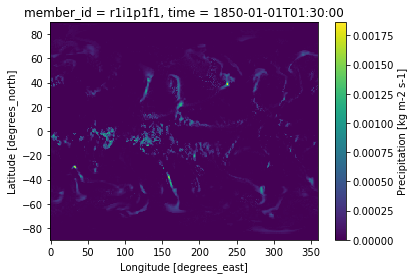

In [13]:
%matplotlib inline
ds.pr.isel(time=0).plot()

We can execute more searches against the original catalog and/or against a subset of the original catalog:

In [ ]:
%%time
cat_fx = col.search(table_id='Ofx', grid_label='gn',
                    variable_id='volcello')
cat_fx.df.head()

In [ ]:
%%time
a = cat_fx.search(source_id="CESM2")
a.df.head()

In [ ]:
len(cat_fx.df), len(a.df)